# Data Expo 2009 - Airline on-time performance
## by (mahmoud lotfi)

## Investigation Overview

01. Which Airlines have the longest delays?
02. What is the worst time of day to travel?
03. Flight delay reasons and how much they contribute to the number of delayed flights?

## Dataset Overview

- The data consists of flight arrival and departure details for all commercial flights within the USA, from October 1987 to April 2008. 
- This is a large dataset: there are nearly 120 million records in total, and takes up 1.6 gigabytes of space compressed and 12 gigabytes when uncompressed. 
- The data comes originally from RITA where it is described in detail. 
- the data in bzipped csv file. 
- These files have derivable variables removed, are packaged in yearly chunks and have been more heavily compressed than the originals.
- in this project we will discuss flight delay for __2008__ data set

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# reset seaborn settings
sns.reset_orig()
# set plotting color
base_color = sns.color_palette()[0]

In [3]:
# load in the dataset into a pandas dataframe
t1 = time.time()
flights = pd.read_csv('../data/processed/{}.csv'.format('flights'))
t2 = time.time()
print('Elapsed loading time :', t2-t1)

Elapsed loading time : 13.10199236869812


> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## 01. Which Airlines have the longest delays

> WN was the worste airline for departures delay, while AS,NW was the worst for arrivals.

In [16]:
longest = flights[flights['ArrDelay']>15].groupby('UniqueCarrier')\
                .agg(DepDelayMean=('DepDelay', 'mean'), ArrDelayMean=('ArrDelay', 'mean'))\
                .sort_values('ArrDelayMean', ascending=False)

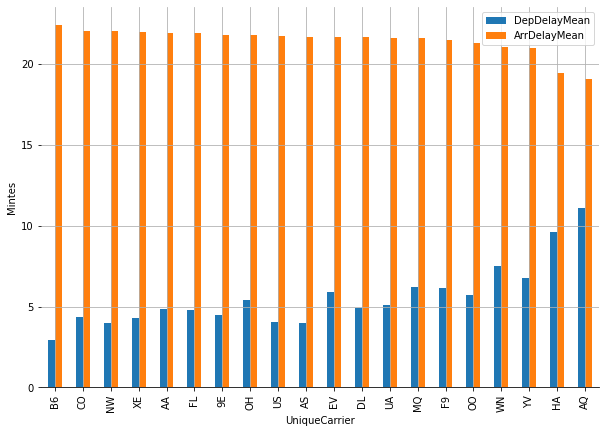

In [17]:
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
longest.plot.bar(ax=ax);
plt.ylabel('Mintes')
plt.grid()

## 02.What is the worst time of day to travel?
> the worst dealy around 06 AM

In [18]:
flights['hours'] = pd.to_datetime(flights['CRSDepTime'], format='%I:%M %p').dt.hour
flights['minutes'] = pd.to_datetime(flights['CRSDepTime'], format='%I:%M %p').dt.minute
flights = flights.sort_values(['hours', 'minutes'])
flights = flights.drop(columns=['minutes'])
df = flights[(flights['ArrDelay'] > 15)].groupby('hours')\
                .agg(ArrDelayCount=('ArrDelay', 'count'), ArrDelaysum=('ArrDelay', sum)) 
df = df.reset_index()

In [19]:
df['ArrDelayAvg'] = (df['ArrDelaysum']/df['ArrDelayCount']).round(2)

In [20]:
df.head()

,hours,ArrDelayCount,ArrDelaysum,ArrDelayAvg
0,0,168,3528,21.00
1,1,42,849,20.21
2,2,13,294,22.62
3,3,2,37,18.50
4,4,10,210,21.00


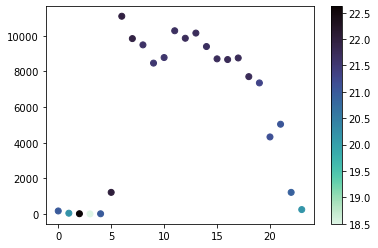

In [21]:
plt.scatter(data = df, x='hours', y='ArrDelayCount', c='ArrDelayAvg',cmap='mako_r');
plt.colorbar();

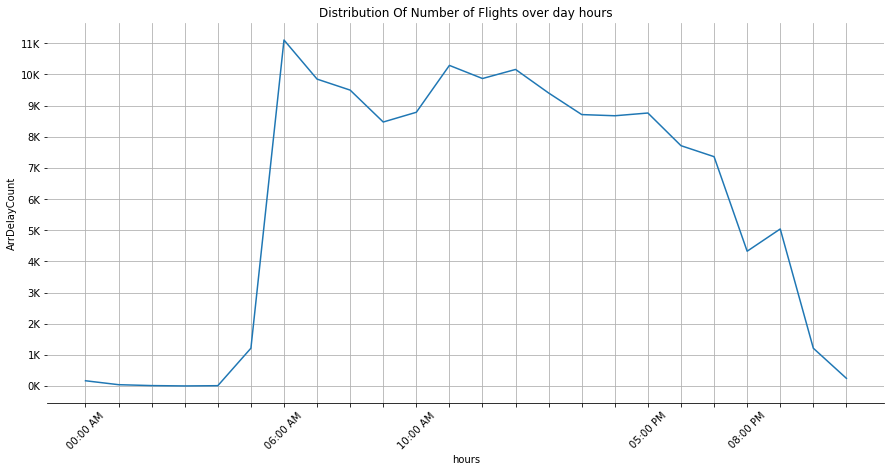

In [33]:
time_tick3 = ['00:00 AM', '', '', '', '', '',
              '06:00 AM', '', '', '', '10:00 AM', '','', '', 
              '', '', '', '05:00 PM', '', '', '08:00 PM', '', '', '']
order = df.index
max_count = df['ArrDelayCount'].max()
max_prop = max_count/1000
tick_prop = np.arange(0, max_prop, 1)
tick_names = ['{:0.0f}K'.format(v) for v in tick_prop]
plt.figure(figsize=(15,7))
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.yticks(tick_prop*1000, tick_names)
plt.xticks(ticks = df.index, labels = time_tick3, rotation=45)
sns.lineplot(data = df, x='hours', y='ArrDelayCount', ax =ax);
plt.title("Distribution Of Number of Flights over day hours")
plt.grid()

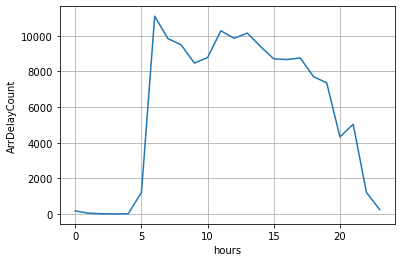

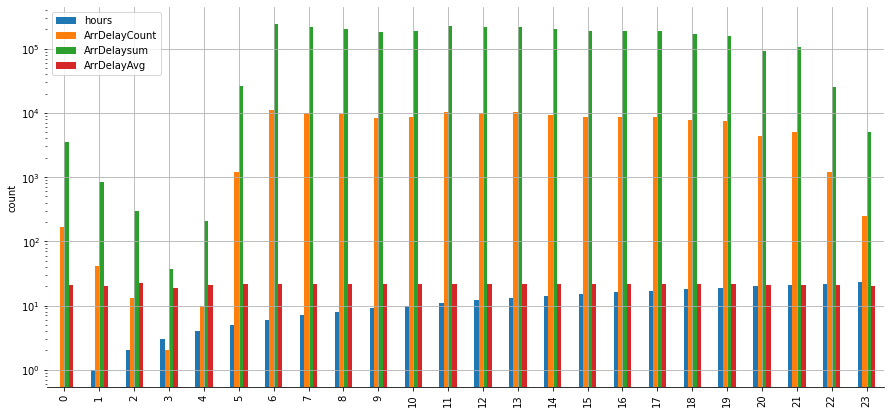

In [25]:
plt.figure(figsize=(15,7))
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
df.plot.bar(ax=ax);
plt.ylabel('count')
plt.yscale('log')
plt.grid()

## 03. Flight delay reasons and how much they contribute to the number of delayed flights

>We also see that the weather is not the main reason for delays. Weather only contributes to 2% of the delays.


In [34]:
df_row = pd.merge(flights.groupby(['UniqueCarrier']).agg(UniqueCarrierCount=('UniqueCarrier', 'count')), 
                  flights[(flights['ArrDelay'] > 15)].groupby(['UniqueCarrier']).agg(ArrDelaycount=('ArrDelay', 'count')),
                  on='UniqueCarrier', how='inner')

In [35]:
df_delay = flights[(flights['ArrDelay'] > 15)]

In [36]:
df_delay = df_delay[(flights['LateAircraftDelay'] != 0) | (flights['SecurityDelay'] != 0) |
        (flights['NASDelay'] != 0) | (flights['WeatherDelay'] != 0) | 
        (flights['CarrierDelay'] != 0) | (flights['WeatherDelay'] != 0)]

In [37]:
df_delay['LateAircraftDelay'] = df_delay['LateAircraftDelay'].apply(lambda x: 1 if x else 0)
df_delay['SecurityDelay'] = df_delay['SecurityDelay'].apply(lambda x: 1 if x else 0)
df_delay['NASDelay'] = df_delay['NASDelay'].apply(lambda x: 1 if x else 0)
df_delay['WeatherDelay'] = df_delay['WeatherDelay'].apply(lambda x: 1 if x else 0)
df_delay['CarrierDelay'] = df_delay['CarrierDelay'].apply(lambda x: 1 if x else 0)

In [38]:
df_delay = df_delay.groupby(['UniqueCarrier']).agg(
    # Get count of the column for each group
    LateAircraftDelayCount=('LateAircraftDelay', sum),
    # Get count of the column for each group
    SecurityDelayCount=('SecurityDelay', sum),
    # Get count of the column for each group
    NASDelayCount=('NASDelay', sum),
    # Get count of the column for each group
    WeatherDelayCount=('WeatherDelay', sum),
    # Get count of the column for each group
    CarrierDelayCount=('CarrierDelay', sum),   
)

In [39]:
df_delay = pd.merge(df_delay, df_row,  on='UniqueCarrier', how='inner')

In [40]:
df_delay['pct'] = (df_delay['ArrDelaycount'].astype(float)/df_delay['UniqueCarrierCount'].astype(float)).round(2)

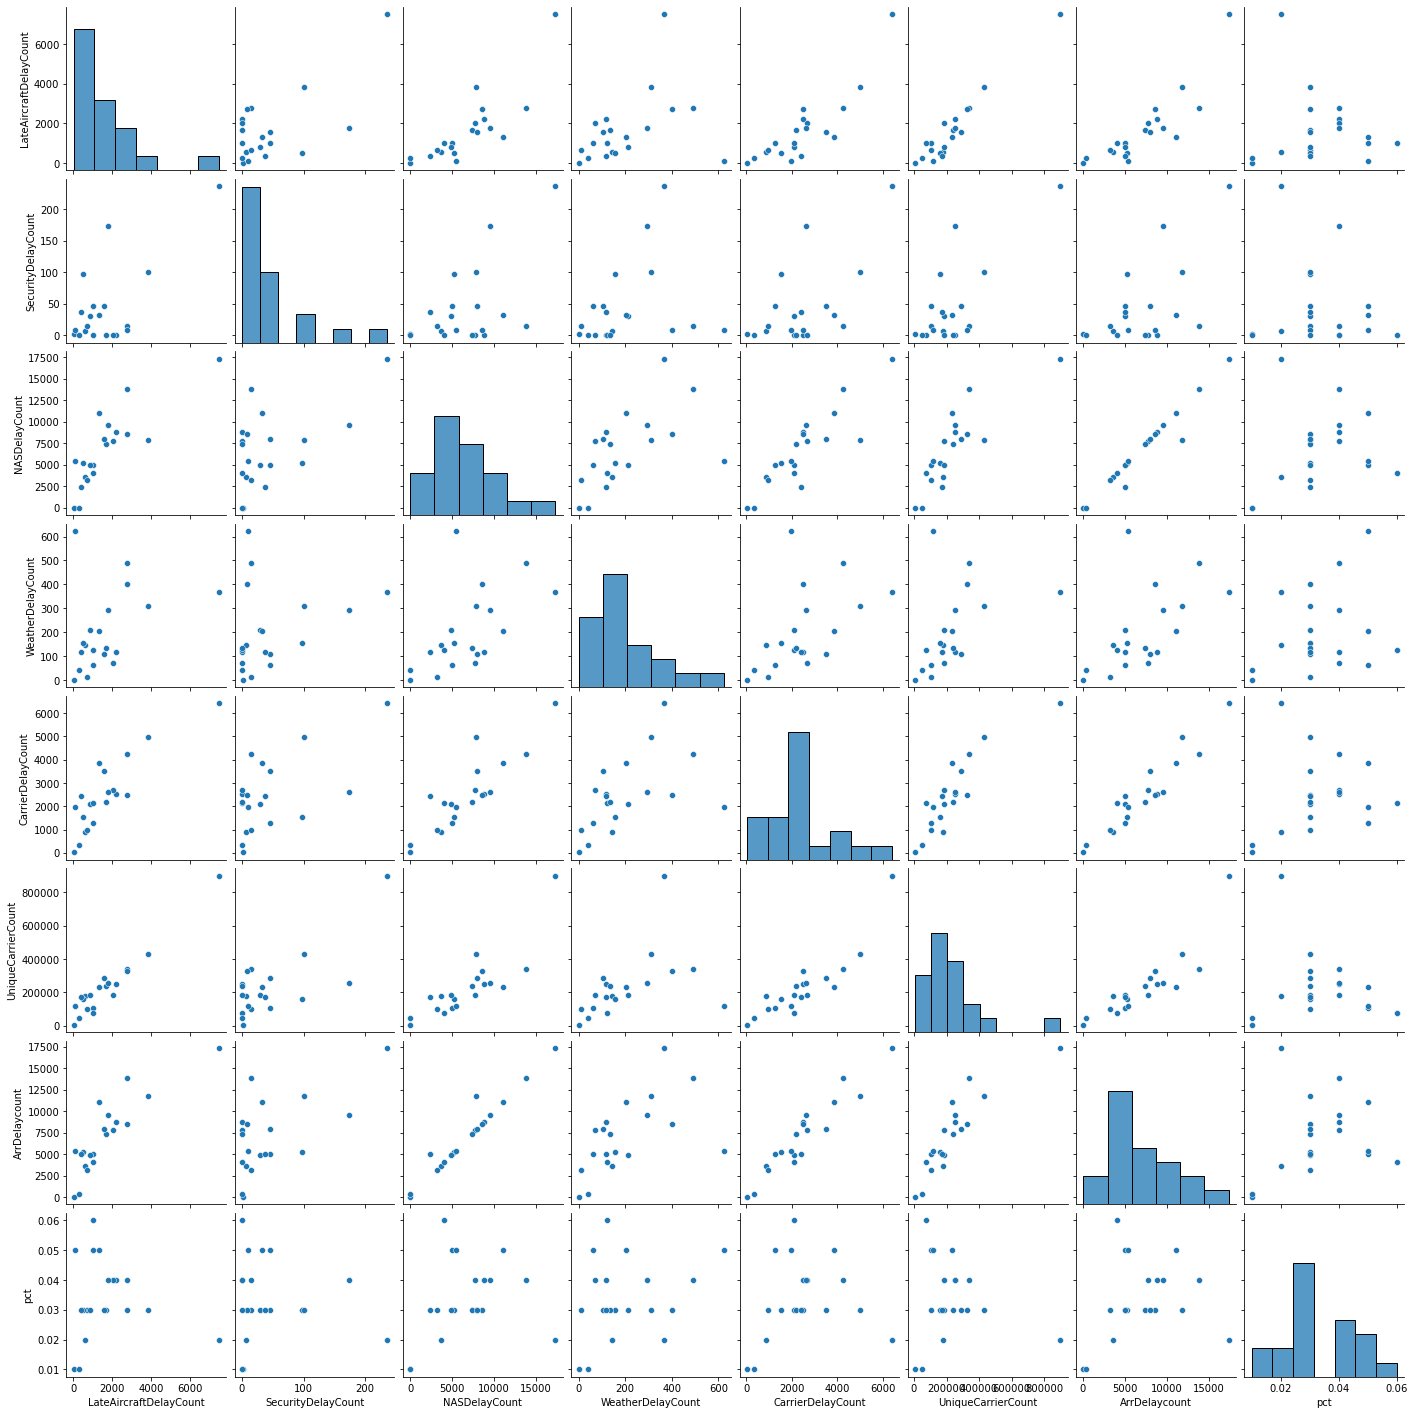

In [42]:
sns.pairplot(df_delay, size = 2.5);

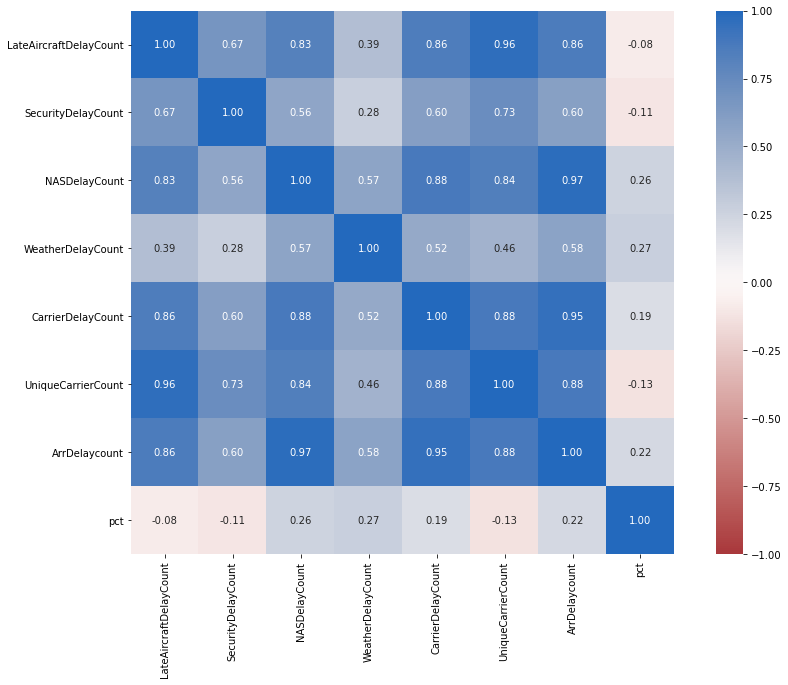

In [43]:
#correlation matrix
corrmat = df_delay.corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmin=-1, square=True, annot=True, fmt='.2f', cmap='vlag_r', center=0);

In [44]:
df_delay['pct'] = (df_delay['ArrDelaycount'].astype(float)/df_delay['UniqueCarrierCount'].astype(float)).round(2)

In [45]:
df_delay.head()

,LateAircraftDelayCount,SecurityDelayCount,NASDelayCount,WeatherDelayCount,CarrierDelayCount,UniqueCarrierCount,ArrDelaycount,pct
UniqueCarrier,,,,,,,,
9E,578,7,3620,145,883,177627,3620,0.02
AA,2763,14,13806,491,4248,340780,13806,0.04
AQ,13,2,1,0,23,6519,38,0.01
AS,1007,46,5016,62,1270,106312,5016,0.05
B6,683,15,3178,11,962,102867,3179,0.03


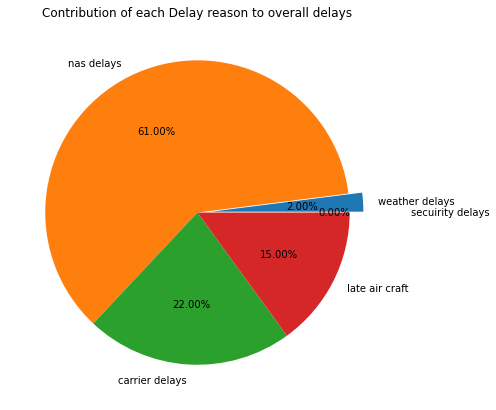

In [41]:
wethear_sum   = df_delay['WeatherDelayCount'].sum()
nas_sum       = df_delay['NASDelayCount'].sum()
carrier_sum   = df_delay['CarrierDelayCount'].sum()
security_sum  = df_delay['SecurityDelayCount'].sum()
aircraft_sum  = df_delay['LateAircraftDelayCount'].sum()
#ArrDelaycount_sum = df_delay['ArrDelaycount'].sum()

num_of_overall = wethear_sum + nas_sum + carrier_sum + security_sum + aircraft_sum

wethear_sum  = (wethear_sum/num_of_overall).round(2)*100
nas_sum      = (nas_sum/num_of_overall).round(2)*100
carrier_sum  = (carrier_sum/num_of_overall).round(2)*100
security_sum = (security_sum/num_of_overall).round(2)*100
aircraft_sum = (aircraft_sum/num_of_overall).round(2)*100

plt.figure(figsize=(10,7))
X = ['weather delays' , 'nas delays','carrier delays','late air craft','secuirity delays']
Y = [wethear_sum, nas_sum, carrier_sum, aircraft_sum, security_sum]
plt.pie(Y, labels=X , explode=[0.09,0,0,0,0.3],  autopct='%1.2f%%');
plt.title('Contribution of each Delay reason to overall delays');

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!